In [8]:
import numpy as np
import matplotlib.pyplot as plt

import datetime
from ctypes import byref
from HH import *

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 15
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["lines.linewidth"] = 1

loadHHLibrary()

HH library version is 3.0


In [9]:
tacq = 10000  # Measurement time in millisec, you can change this
binning = 0  # you can change this
offset = 0
syncDivider = 1  # you can change this
syncCFDZeroCross = 0  # you can change this (in mV)
syncCFDLevel = 600  # you can change this (in mV)
syncChannelOffset = -5000  # you can change this (in ps, like a cable delay)
inputCFDZeroCross = 0  # you can change this (in mV)
inputCFDLevel = 600  # you can change this (in mV)
inputChannelOffset = 0  # you can change this (in ps, like a cable delay)

now = datetime.datetime.now()
filename = "data/histomode_" + str(now) + ".csv"
outputfile = open(filename, "w+")

outputfile.write("Binning           : %d\n" % binning)
outputfile.write("Offset            : %d\n" % offset)
outputfile.write("AcquisitionTime   : %d\n" % tacq)
outputfile.write("SyncDivider       : %d\n" % syncDivider)
outputfile.write("SyncCFDZeroCross  : %d\n" % syncCFDZeroCross)
outputfile.write("SyncCFDLevel      : %d\n" % syncCFDLevel)
outputfile.write("InputCFDZeroCross : %d\n" % inputCFDZeroCross)
outputfile.write("InputCFDLevel     : %d\n" % inputCFDLevel)

loadDevice()
getDeviceInfo()


Searching for HydraHarp devices...
Dev_idx     Status
  0        S/N 1999999
  1        no device
  2        no device
Using device #0

Initializing the device...
Found Model HydraHarp 400 Part no 930020 Version 2.0
Device has 4 input channels.


In [10]:
setEverything(
    binning=binning,
    offset=offset,
    syncDivider=syncDivider,
    syncCFDZeroCross=syncCFDZeroCross,
    syncCFDLevel=syncCFDLevel,
    syncChannelOffset=syncChannelOffset,
    inputCFDZeroCross=inputCFDZeroCross,
    inputCFDLevel=inputCFDLevel,
    inputChannelOffset=inputChannelOffset,
)


# funny
tryfunc(
    hhlib.HH_SetInputChannelOffset(ct.c_int(dev[0]), ct.c_int(1), ct.c_int(330)),
    "SetInputChannelOffset",
)

tryfunc(hhlib.HH_GetResolution(ct.c_int(dev[0]), byref(resolution)), "GetResolution")
outputfile.write("Resolution        : %d\n" % resolution.value)
print("Resolution is %1.1lfps" % resolution.value)


Calibrating...
Histogram length is 65536
Resolution is 1.0ps


In [11]:
getSyncCountRates()
getWarnings()

tryfunc(
    hhlib.HH_SetStopOverflow(ct.c_int(dev[0]), ct.c_int(0), ct.c_int(10000)),
    "SetStopOverflow",
)  # for example only

Syncrate=40000120/s
Countrate[0]=0/s
Countrate[1]=0/s
Countrate[2]=316400/s
Countrate[3]=215520/s


WARNING_SYNC_RATE_TOO_HIGH: 
The pulse rate at the sync input is too high. 
If your sync source is periodic you can try 
setting a larger sync divider. 





In [ ]:
## this block can be run multiple times

tryfunc(hhlib.HH_ClearHistMem(ct.c_int(dev[0])), "ClearHistMem")

# measurement
tryfunc(hhlib.HH_StartMeas(ct.c_int(dev[0]), ct.c_int(tacq)), "StartMeas")
print("\nMeasuring for %1d milliseconds..." % tacq)
ctcstatus = ct.c_int(0)
while ctcstatus.value == 0:
    tryfunc(hhlib.HH_CTCStatus(ct.c_int(dev[0]), byref(ctcstatus)), "CTCStatus")
tryfunc(hhlib.HH_StopMeas(ct.c_int(dev[0])), "StopMeas")

for i in range(0, numChannels.value):
    tryfunc(
        hhlib.HH_GetHistogram(
            ct.c_int(dev[0]), byref(counts[i]), ct.c_int(i), ct.c_int(1)
        ),
        "GetHistogram",
    )
    integralCount = 0
    for j in range(0, histLen.value):
        integralCount += counts[i][j]
    print("  Integralcount[%1d]=%1.0lf" % (i, integralCount))
tryfunc(hhlib.HH_GetFlags(ct.c_int(dev[0]), byref(flags)), "GetFlags")
if flags.value & FLAG_OVERFLOW > 0:
    print("  Overflow.")

print("Quit and save the count data.")

Syncrate=40000080/s
Countrate[0]=0/s
Countrate[1]=0/s
Countrate[2]=319680/s
Countrate[3]=213480/s

Measuring for 10000 milliseconds...
  Integralcount[0]=0
  Integralcount[1]=0
  Integralcount[2]=1197948
  Integralcount[3]=758935
Quit and save the count data.


In [13]:
#writing to file and quitting
for j in range(0, histLen.value):
    for i in range(0, numChannels.value):
        outputfile.write("%5d " % counts[i][j])
    outputfile.write("\n")

closeDevices()
outputfile.close()

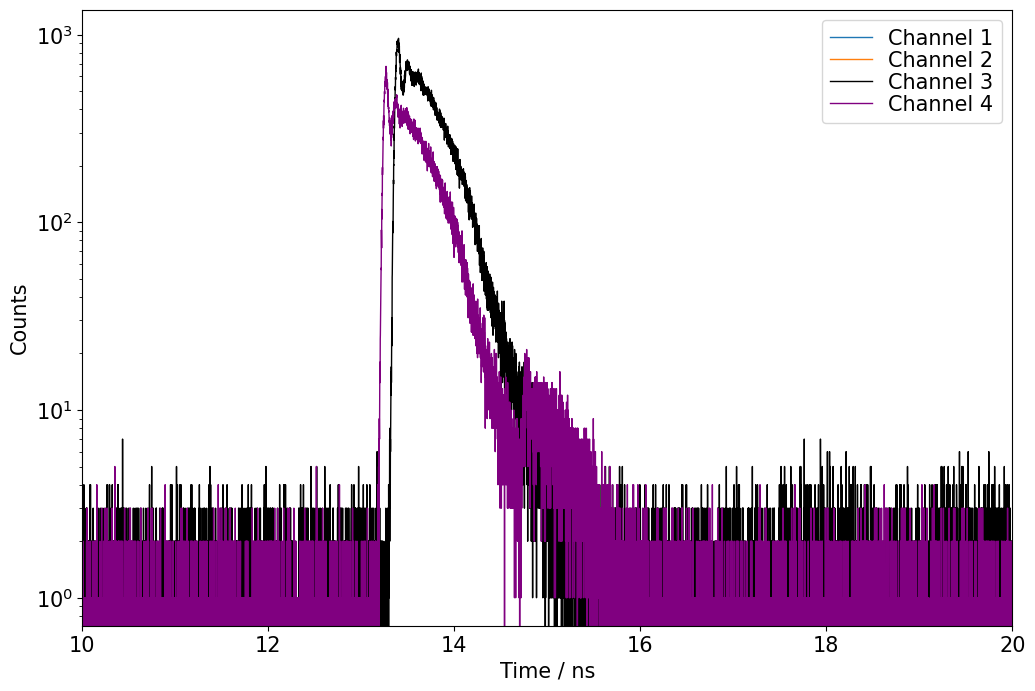

In [16]:
data = np.loadtxt(filename, skiprows=9)
row1 = data[:, 0]
row2 = data[:, 1]
row3 = data[:, 2]
row4 = data[:, 3]

T = np.linspace(0, len(row1), len(row1)) / 1000


plt.plot(T, row1, label="Channel 1", color="#1f77b4")
plt.plot(T, row2, label="Channel 2", color="#ff7f0e")
plt.plot(T, row3, label="Channel 3", color="black")
plt.plot(T + 0.342, row4, label="Channel 4", color="purple")

# bins_time = np.linspace(min(T), max(T), 5000)  # 5 przedziałów czasowych
# binnin_res=(bins_time[1]-bins_time[0])*1e3 #ps
# print("Bins",binnin_res," ps")
# plt.hist(T, bins=bins_time, weights=row1,color="red")

plt.legend()
plt.xlim(10, 20)
plt.xlabel("Time / ns")
plt.ylabel("Counts")
plt.yscale("log")

# plt.title("3C4Z")
plt.savefig(filename.replace(".csv", ".png"))

In [14]:
dataA = np.loadtxt("data/histomode_2025-09-10 15:48:37.864578.csv", skiprows=9)
dataB = np.loadtxt("data/histomode_2025-09-10 15:50:40.505662.csv", skiprows=9)

ch1A = dataA[:, 2]
ch2A = dataA[:, 3]

ch1B = dataB[:, 2]
ch2B = dataB[:, 3]


def f(data):
    maxi = 0
    ptrMaxi = 0
    for i in range(0, 20000):
        if data[i] > maxi:
            maxi = data[i]
            ptrMaxi = i
    return ptrMaxi


print(f(ch1A), f(ch2A), -f(ch2A) + f(ch1A))
print(f(ch1B), f(ch2B), -f(ch2B) + f(ch1B))

hpd = max(-f(ch2B) + f(ch1B), -f(ch2A) + f(ch1A))
hmd = min(-f(ch2B) + f(ch1B), -f(ch2A) + f(ch1A))

print("Hydra's delay:", (hpd + hmd) / 2)
print("Path delay:", (hpd - hmd) / 2)

13269 13056 213
13395 12924 471
Hydra's delay: 342.0
Path delay: 129.0
